# Importing Essential Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

# Digit MNIST

<img src="https://www.researchgate.net/publication/334571446/figure/fig1/AS:783175043276803@1563734889936/Bangla-sign-language-digits-sample.png" alt="Image" style="width:600px;height:300px;margin:auto">

# Loading the Digit's DataSet

In [5]:
root_dir = '/kaggle/input/american-sign-language-digit-dataset/American Sign Language Digits Dataset'

image_data = []

for label in range(10):
    label_dir = os.path.join(root_dir, str(label), 'Input Images - Sign {}'.format(label))
    for image_file in os.listdir(label_dir):
        image = Image.open(os.path.join(label_dir, image_file))
        image_data.append({
            'label': label,
            'color_image': image
        })

df = pd.DataFrame(image_data)

In [7]:
df.sample(3)

,label,color_image
3626,7,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1966,3,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4289,8,<PIL.JpegImagePlugin.JpegImageFile image mode=...


# Data Visualization (EDA)

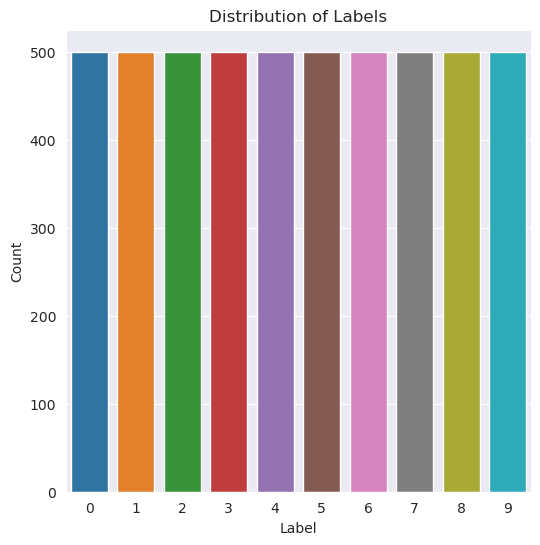

In [8]:
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=df,x='label')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

plt.show()

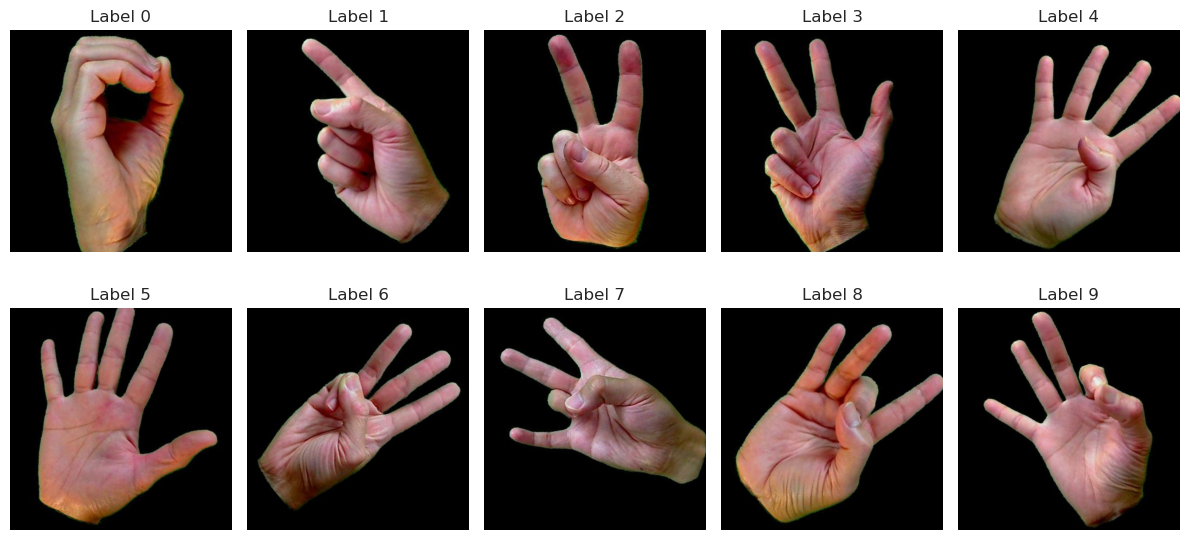

In [9]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i, (label, image) in enumerate(df.groupby('label').first().reset_index()[['label', 'color_image']].itertuples(index=False)):
    ax = axs[i // 5, i % 5]
    ax.imshow(image)
    ax.set_title('Label {}'.format(label))
    ax.axis('off')

plt.axis('off')
plt.tight_layout()
plt.show()

# Data Preprocessing

In [10]:
# Preprocessing steps
images = np.array(df['color_image'].tolist())
labels = np.array(df['label'])

In [12]:
# Resize images to desired dimensions
resized_images = []
for image in images:
    resized_image = image.resize((32, 32))  # Resize the image to the desired size
    resized_images.append(np.array(resized_image))
images = np.array(resized_images)

In [13]:
# Normalize pixel values
images = images / 255.0

# Splitting the Data into Train Test Split

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [16]:
# Convert labels to categorical format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Model Architecture

In [17]:
model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(50, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(25, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=10, activation='softmax'))

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 75)        2100      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 16, 16, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 50)       2

# Data Augmentation

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# Fitting of the Model

In [19]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.0001)
history = model.fit(datagen.flow(X_train, y_train), epochs=30, validation_data=(X_test, y_test), callbacks=[learning_rate_reduction])

Epoch 1/30


2023-07-22 22:57:12.700778: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 15s 27ms/step - loss: 1.6212 - accuracy: 0.4410 - val_loss: 2.4414 - val_accuracy: 0.0810 - lr: 0.0100
Epoch 2/30
125/125 [==============================] - 3s 23ms/step - loss: 0.7982 - accuracy: 0.7287 - val_loss: 2.5299 - val_accuracy: 0.1620 - lr: 0.0100
Epoch 3/30
125/125 [==============================] - 3s 24ms/step - loss: 0.5020 - accuracy: 0.8363 - val_loss: 1.8668 - val_accuracy: 0.3620 - lr: 0.0100
Epoch 4/30
125/125 [==============================] - 3s 23ms/step - loss: 0.3584 - accuracy: 0.8835 - val_loss: 0.5474 - val_accuracy: 0.8670 - lr: 0.0100
Epoch 5/30
125/125 [==============================] - 3s 24ms/step - loss: 0.2696 - accuracy: 0.9172 - val_loss: 0.1880 - val_accuracy: 0.9750 - lr: 0.0100
Epoch 6/30
125/125 [==============================] - 4s 29ms/step - loss: 0.2155 - accuracy: 0.9373 - val_loss: 0.0936 - val_accuracy: 0.9870 - lr: 0.0100
Epoch 7/30
125/125 [==============================] - 3s 23ms/step - loss:

# Model Evaluation

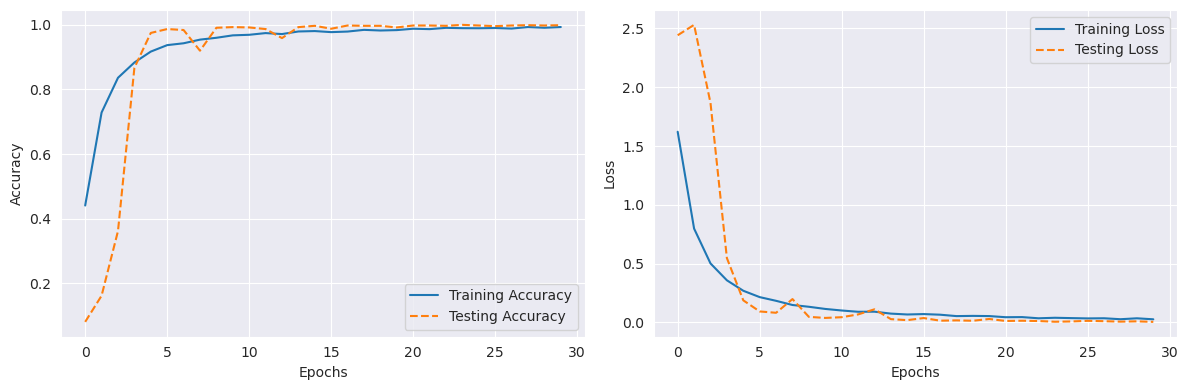

In [20]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Define plot labels and styles
plot_labels = ['Accuracy', 'Loss']
plot_styles = ['-', '--']

# Plot training and testing accuracy/loss
for i, metric in enumerate(['accuracy', 'loss']):
    train_metric = history.history[metric]
    test_metric = history.history['val_' + metric]
    axs[i].plot(train_metric, label='Training ' + metric.capitalize(), linestyle=plot_styles[0])
    axs[i].plot(test_metric, label='Testing ' + metric.capitalize(), linestyle=plot_styles[1])
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel(plot_labels[i])
    axs[i].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [21]:
# Get the model's predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

32/32 [==============================] - 0s 3ms/step


In [23]:
# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm

array([[111,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 105,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 105,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  85,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  94,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  98,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  98,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 112,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  81,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   0, 110]])

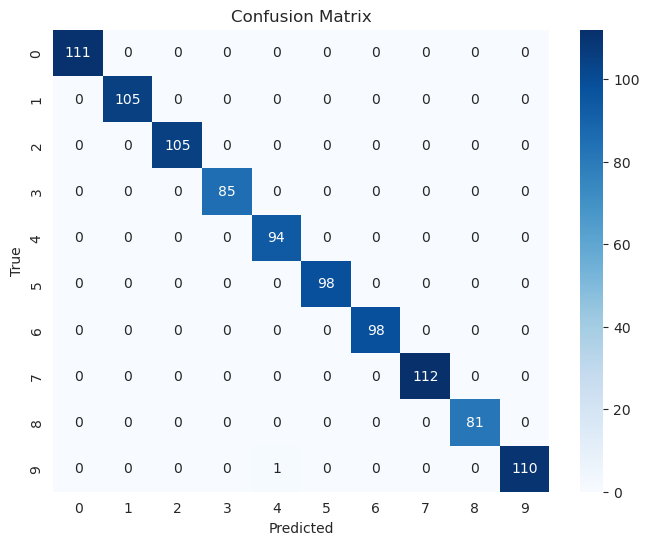

In [24]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
accuracy = model.evaluate(X_test, y_test)
print(f'validation test results - Loss: {accuracy[0]} - Accuracy: {accuracy[1]*100}%')

32/32 [==============================] - 0s 4ms/step - loss: 0.0051 - accuracy: 0.9990
validation test results - Loss: 0.005064653232693672 - Accuracy: 99.90000128746033%


# Saving the Model

In [26]:
model.save("digitSignLanguage.h5")

# <center> -----------------------------  END   ---------------------------</center>

# ASL (American Sign Language)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/American_Sign_Language_ASL.svg/1200px-American_Sign_Language_ASL.svg.png" alt="Image" style="width:600px;height:300px;margin:auto">

# Loading the Dataset

In [27]:
train_df = pd.read_csv("../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

In [28]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


# Data Visualization (EDA)

In [29]:
fig = px.histogram(train_df, x='label',color='label', title='Distribution of Labels in Training Dataset')

fig.update_layout(
    xaxis_title='Label',
    yaxis_title='Count',
    showlegend=False,
    bargroupgap=0.1,
)

fig.show()

In [30]:
fig = px.histogram(test_df, x='label',color='label', title='Distribution of Labels in Testing Dataset')

fig.update_layout(
    xaxis_title='Label',
    yaxis_title='Count',
    showlegend=False,
    bargroupgap=0.1,
)

fig.show()

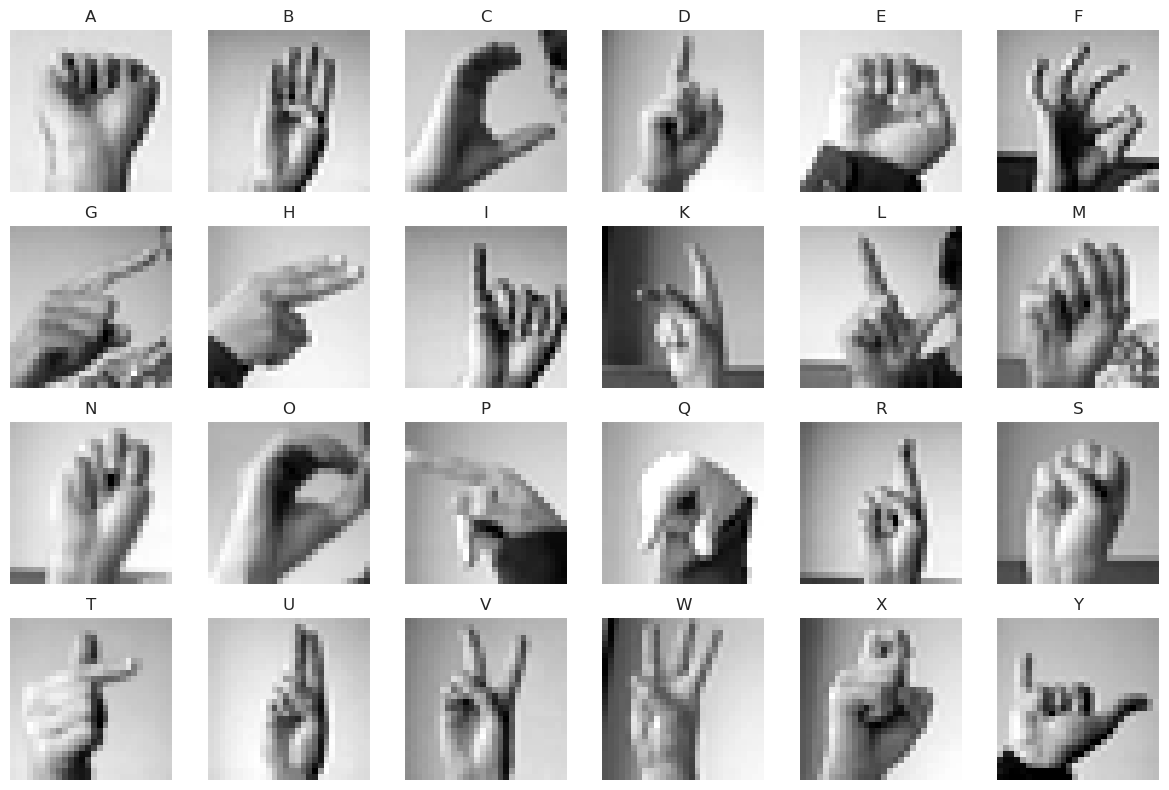

In [31]:
# Group the dataframe by the 'label' column
label_groups = train_df.groupby('label')

# Iterate over each label group and display one image
fig, axs = plt.subplots(4, 6, figsize=(12, 8))

for i, (label, group) in enumerate(label_groups):
    # Get the first image from the group
    image = group.iloc[0, 1:].values.reshape(28, 28)
    
    # Calculate the subplot index
    row = i // 6
    col = i % 6
    
    # Convert label to integer and add 65 to get ASCII value
    ascii_value = int(label) + 65
    
    # Display the image
    axs[row, col].imshow(image, cmap='gray')
    axs[row, col].set_title(chr(ascii_value))
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

# Preprocessing the Data

In [32]:
X_train = train_df.drop(labels = ["label"],axis = 1) 
y_train = train_df["label"]

In [33]:
X_test = test_df.drop(labels = ["label"],axis = 1)
y_test = test_df["label"]

In [34]:
X_train = np.array(X_train, dtype='float32')
X_test = np.array(X_test, dtype='float32')
y_train = np.array(y_train, dtype='float32')
y_test = np.array(y_test, dtype='float32')

In [35]:
# Reshape the data to match the input shape of the CNN
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [36]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [37]:
# Convert the labels to one-hot encoded format
num_classes = 25
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

In [38]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(27455, 28, 28, 1)
(27455, 25)
(7172, 28, 28, 1)
(7172, 25)


# Model Architecture

In [39]:
# Create the CNN model
model = Sequential()
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(num_classes, activation = "softmax"))

# Compile the model
model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),loss='categorical_crossentropy',metrics=['accuracy'])

# Data Augmentation

In [40]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# Fitting of the Model

In [41]:
#Training the model
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=3,factor=0.5, min_lr=0.0001)

history = model.fit_generator(datagen.flow(X_train,y_train), epochs = 25, validation_data = (X_test,y_test), verbose = 1, callbacks=[learning_rate_reduction])

Epoch 1/25


2023-07-22 23:04:14.107167: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


858/858 [==============================] - 18s 20ms/step - loss: 1.0578 - accuracy: 0.6706 - val_loss: 0.1989 - val_accuracy: 0.9261 - lr: 0.0010
Epoch 2/25
858/858 [==============================] - 16s 19ms/step - loss: 0.1796 - accuracy: 0.9426 - val_loss: 0.0193 - val_accuracy: 0.9957 - lr: 0.0010
Epoch 3/25
858/858 [==============================] - 17s 19ms/step - loss: 0.0983 - accuracy: 0.9694 - val_loss: 0.0363 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 4/25
858/858 [==============================] - 15s 18ms/step - loss: 0.0710 - accuracy: 0.9779 - val_loss: 0.0087 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 5/25
858/858 [==============================] - 17s 19ms/step - loss: 0.0571 - accuracy: 0.9839 - val_loss: 0.0057 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 6/25
858/858 [==============================] - 16s 19ms/step - loss: 0.0496 - accuracy: 0.9860 - val_loss: 0.0297 - val_accuracy: 0.9944 - lr: 0.0010
Epoch 7/25
858/858 [==============================] - 16s 19ms/step -

# Model Evaluation

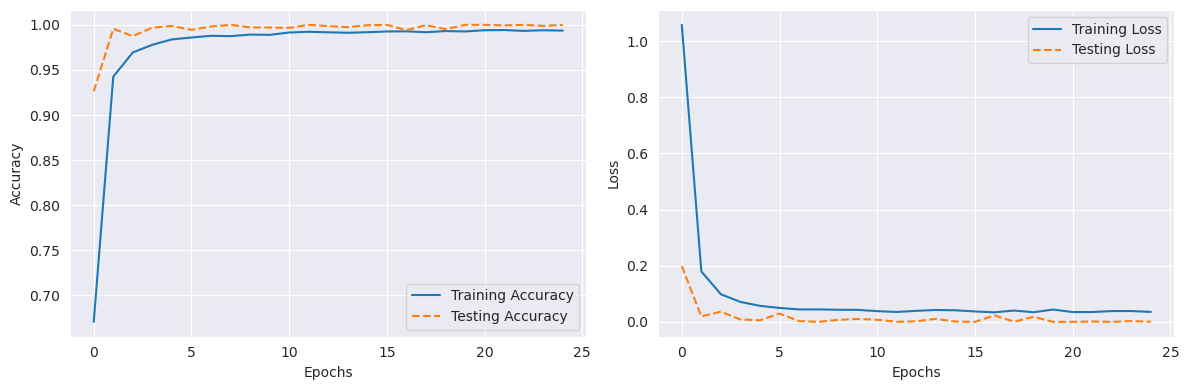

In [42]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Define plot labels and styles
plot_labels = ['Accuracy', 'Loss']
plot_styles = ['-', '--']

# Plot training and testing accuracy/loss
for i, metric in enumerate(['accuracy', 'loss']):
    train_metric = history.history[metric]
    test_metric = history.history['val_' + metric]
    axs[i].plot(train_metric, label='Training ' + metric.capitalize(), linestyle=plot_styles[0])
    axs[i].plot(test_metric, label='Testing ' + metric.capitalize(), linestyle=plot_styles[1])
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel(plot_labels[i])
    axs[i].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [43]:
# Get the model's predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

225/225 [==============================] - 1s 3ms/step


In [44]:
# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

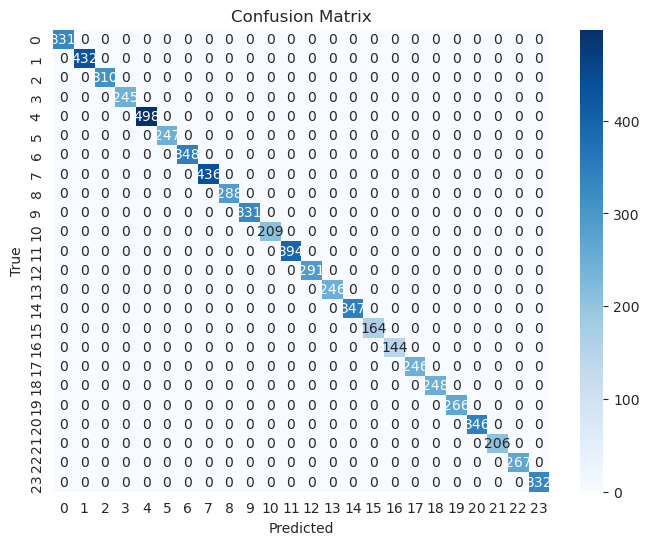

In [45]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [46]:
accuracy = model.evaluate(X_test, y_test)
print(f'validation test results - Loss: {accuracy[0]} - Accuracy: {accuracy[1]*100}%')

225/225 [==============================] - 1s 5ms/step - loss: 5.6123e-04 - accuracy: 1.0000
validation test results - Loss: 0.0005612259265035391 - Accuracy: 100.0%


# Saving the Model

In [47]:
model.save("alphabetSignLanguage.h5")

# <center> -----------------------------  END   ---------------------------</center>